In [41]:
# FINAL REPORT: What drives high Airbnb review scores?

In [42]:
import sys
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score


sns.set(style="whitegrid", palette="muted")
pd.set_option("display.max_columns", None)


project_root = Path.cwd().parent

sys.path.insert(0, str(project_root))

from src.extract import load_csv


In [43]:
# Airbnb Review Score Analysis – Final Report
  
# Understand which listing, host, and location features are strongly associated with higher overall review scores (`review_scores_rating`)

# 1. Summarize the dataset and rating distribution  
# 2. Explore how key features relate to review scores  
# 3. Train a simple model

In [44]:
df = load_csv("listings_transformed.csv", folder="processed")

df

Loaded 17,730 rows from C:\Users\Ross\Desktop\Data Analytics Proj\AirbnbProject\data\processed\listings_transformed.csv


,host_since,last_review,accommodates,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,reviews_per_month,review_scores_rating,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_value,host_listings_count,host_total_listings_count,latitude,longitude,bathrooms,bedrooms,host_response_rate,host_acceptance_rate,host_is_superhost,host_identity_verified,shared_bath,host_response_time,neighbourhood_cleansed,host_tenure_days,host_tenure_years,host_experience_level,days_since_last_review,last_review_year,last_review_month,review_activity_level,bed_bath_ratio,beds_per_guest,reviews_pm_per_guest,occupancy_ratio,review_score_avg,review_score_std,lat_bin,lon_bin,room_type_hotel room,room_type_private room,room_type_shared room,property_type_boat,property_type_camper/rv,property_type_campsite,property_type_casa particular,property_type_dome,property_type_earthen home,property_type_entire bungalow,property_type_entire cabin,property_type_entire condo,property_type_entire cottage,property_type_entire guest suite,property_type_entire guesthouse,property_type_entire home,property_type_entire home/apt,property_type_entire loft,property_type_entire place,property_type_entire rental unit,property_type_entire resort,property_type_entire serviced apartment,property_type_entire townhouse,property_type_entire vacation home,property_type_entire villa,property_type_farm stay,property_type_holiday park,property_type_houseboat,property_type_island,property_type_private room,property_type_private room in bed and breakfast,property_type_private room in bungalow,property_type_private room in cabin,property_type_private room in camper/rv,property_type_private room in casa particular,property_type_private room in chalet,property_type_private room in condo,property_type_private room in cottage,property_type_private room in earthen home,property_type_private room in guest suite,property_type_private room in guesthouse,property_type_private room in home,property_type_private room in hostel,property_type_private room in hut,property_type_private room in loft,property_type_private room in rental unit,property_type_private room in resort,property_type_private room in serviced apartment,property_type_private room in tiny home,property_type_private room in townhouse,property_type_private room in treehouse,property_type_private room in villa,property_type_private room in yurt,property_type_room in aparthotel,property_type_room in boutique hotel,property_type_room in hostel,property_type_room in hotel,property_type_room in serviced apartment,property_type_shared room in bed and breakfast,property_type_shared room in condo,property_type_shared room in guest suite,property_type_shared room in home,property_type_shared room in hostel,property_type_shared room in hotel,property_type_shared room in rental unit,property_type_tent,property_type_tiny home,property_type_train,property_type_treehouse,neighbourhood_freq
0,2009-09-23,2020-03-13,1,90,180,29,59,89,364,193,1.0100,4.59,4.30,4.76,4.82,4.71,1.0,1.0,-33.867670,151.224970,1.0,NaN,0.00,NaN,False,False,True,a few days or more,sydney,5898.0,16.158904,10+ yrs,2074.0,2020.0,3.0,1+ years,NaN,NaN,1.0100,0.002740,4.6475,0.235991,"(-33.883, -33.86]","(151.216, 151.265]",False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.236323
1,2009-12-03,2025-09-01,2,1,90,14,42,63,295,351,3.8300,4.55,4.52,4.75,4.76,4.57,1.0,2.0,-33.879640,151.216800,1.0,NaN,1.00,1.00,False,True,False,within an hour,sydney,5827.0,15.964384,10+ yrs,76.0,2025.0,9.0,< 3 months,NaN,NaN,1.9150,0.191781,4.6500,0.12

In [45]:
print("Rows, Columns:", df.shape)
df.info()

Rows, Columns: (17730, 114)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17730 entries, 0 to 17729
Columns: 114 entries, host_since to neighbourhood_freq
dtypes: bool(70), float64(26), int64(8), object(10)
memory usage: 7.1+ MB


In [47]:
# Keep only rows with non-null review_scores_rating
df = df[df["review_scores_rating"].notnull()].copy()
print("Rows with review_scores_rating:", len(df))

Rows with review_scores_rating: 15020


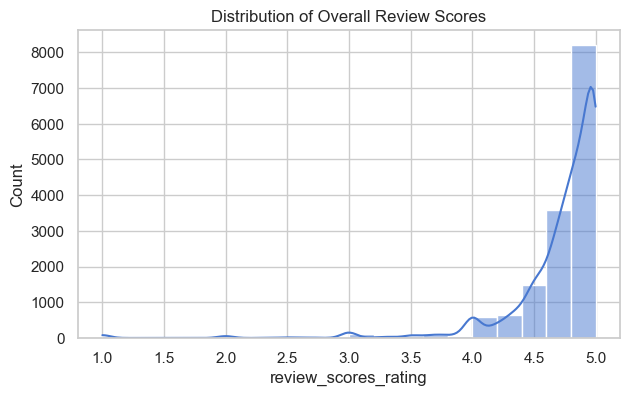

In [48]:
plt.figure(figsize=(7,4))
sns.histplot(df["review_scores_rating"], bins=20, kde=True)
plt.title("Distribution of Overall Review Scores")
plt.xlabel("review_scores_rating")
plt.show()


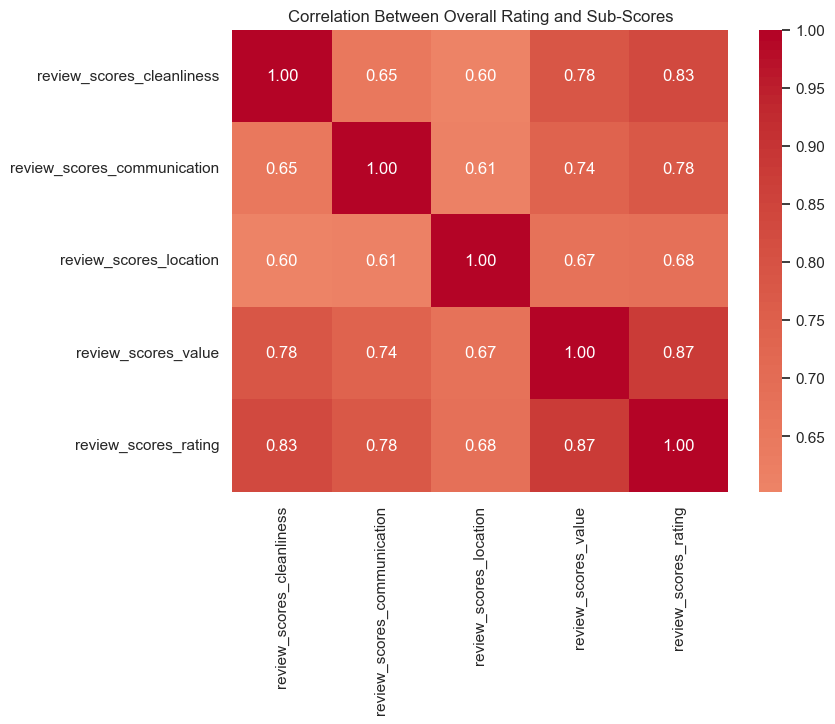

In [50]:
score_cols = [
    "review_scores_accuracy",
    "review_scores_cleanliness",
    "review_scores_checkin",
    "review_scores_communication",
    "review_scores_location",
    "review_scores_value",
]

existing_score_cols = [c for c in score_cols if c in df.columns]
corr = df[existing_score_cols + ["review_scores_rating"]].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Between Overall Rating and Sub-Scores")
plt.show()


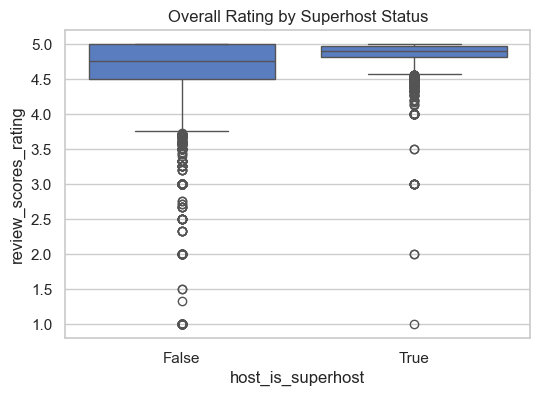

                       mean  count
host_is_superhost                 
False              4.629196   9112
True               4.862432   5357


In [52]:
if "host_is_superhost" in df.columns:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=df, x="host_is_superhost", y="review_scores_rating")
    plt.title("Overall Rating by Superhost Status")
    plt.xlabel("host_is_superhost")
    plt.show()

    print(df.groupby("host_is_superhost")["review_scores_rating"].agg(["mean", "count"]))
else:
    print("host_is_superhost column not found.")


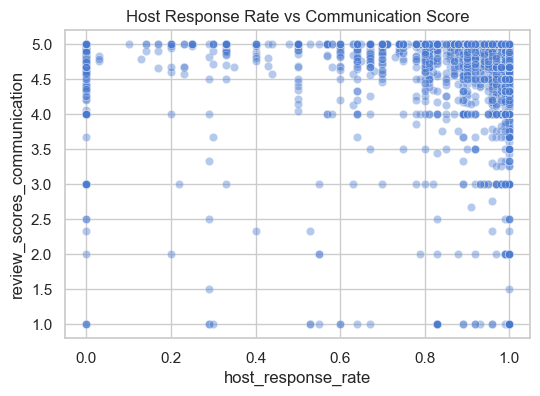

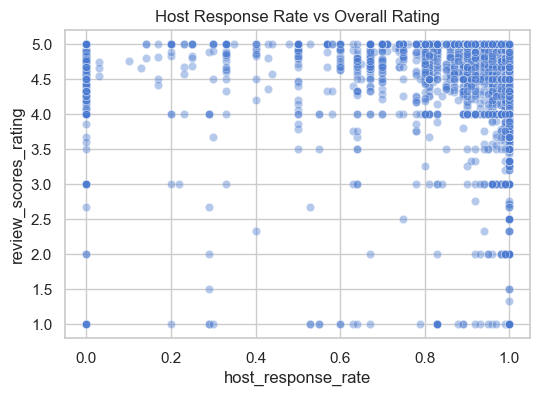

In [54]:
if "host_response_rate" in df.columns:
    plt.figure(figsize=(6,4))
    sns.scatterplot(
        data=df, x="host_response_rate", y="review_scores_communication", alpha=0.4
    )
    plt.title("Host Response Rate vs Communication Score")
    plt.show()

    plt.figure(figsize=(6,4))
    sns.scatterplot(
        data=df, x="host_response_rate", y="review_scores_rating", alpha=0.4
    )
    plt.title("Host Response Rate vs Overall Rating")
    plt.show()
else:
    print("host_response_rate column not found.")


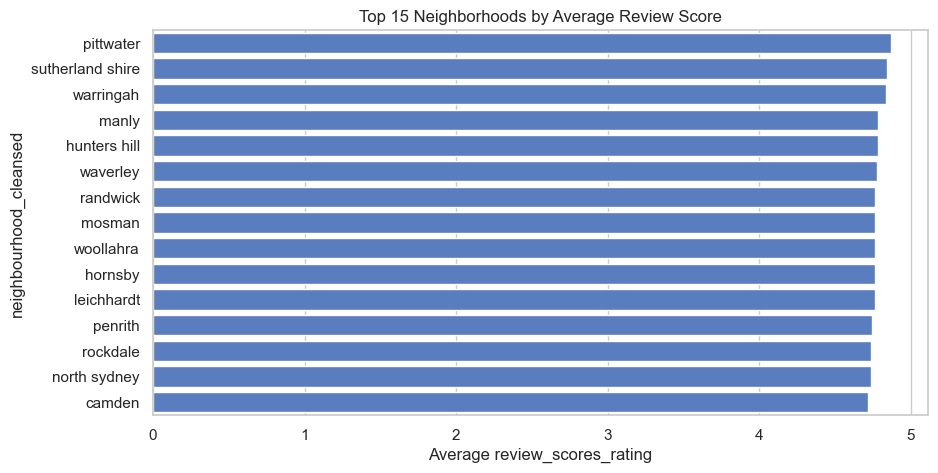

In [56]:
if "neighbourhood_cleansed" in df.columns:
    neigh_means = (
        df.groupby("neighbourhood_cleansed")["review_scores_rating"]
        .mean()
        .sort_values(ascending=False)
        .head(15)
    )

    plt.figure(figsize=(10,5))
    sns.barplot(x=neigh_means.values, y=neigh_means.index)
    plt.title("Top 15 Neighborhoods by Average Review Score")
    plt.xlabel("Average review_scores_rating")
    plt.show()
else:
    print("neighbourhood_cleansed column not found.")


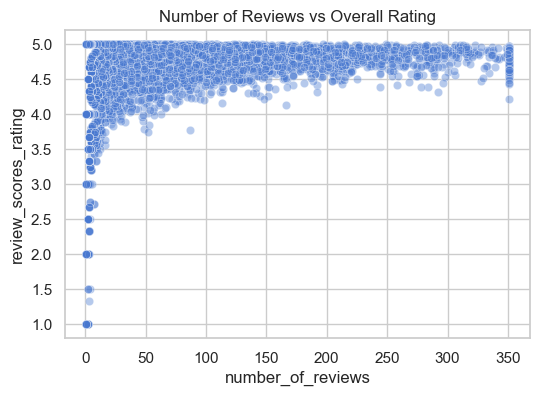

In [58]:
plt.figure(figsize=(6,4))
sns.scatterplot(
    data=df,
    x="number_of_reviews",
    y="review_scores_rating",
    alpha=0.4
)
plt.title("Number of Reviews vs Overall Rating")
plt.xlabel("number_of_reviews")
plt.ylabel("review_scores_rating")
plt.show()


In [60]:
# Select a reasonable feature set for modeling review_scores_rating
candidate_features = [
    "accommodates",
    "bedrooms",
    "bathrooms",
    "minimum_nights",
    "maximum_nights",
    "availability_365",
    "number_of_reviews",
    "reviews_per_month",
    "host_response_rate",
    "host_total_listings_count",
    "host_is_superhost",
    "host_identity_verified",
]

# Keep only features that actually exist
feature_cols = [c for c in candidate_features if c in df.columns]
print("Using features:", feature_cols)

X = df[feature_cols].copy()
y = df["review_scores_rating"].copy()

# Some boolean columns might be dtype 'boolean' -> convert to int
for col in X.columns:
    if X[col].dtype == "boolean":
        X[col] = X[col].astype("int")

# Drop rows with missing feature values
model_data = pd.concat([X, y], axis=1).dropna(subset=feature_cols + ["review_scores_rating"])
X = model_data[feature_cols]
y = model_data["review_scores_rating"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae, r2


Using features: ['accommodates', 'bedrooms', 'bathrooms', 'minimum_nights', 'maximum_nights', 'availability_365', 'number_of_reviews', 'reviews_per_month', 'host_response_rate', 'host_total_listings_count', 'host_is_superhost', 'host_identity_verified']


(0.1785934890210512, 0.08398434994154735)

In [61]:
# Model Performance – How Well Can We Predict Review Scores?

# Report:

# - **MAE (Mean Absolute Error):** ≈ _X.X_  
# - **R² (Explained Variance):** ≈ _Y.Y_

# Interpretation:

# - MAE tells us the typical absolute error in review score points.  
# - R² tells us how much of the variation in review scores is explained by the features included.  
# - We are not chasing a perfect model here; we just want a reasonable measure so we can interpret which features matter most.


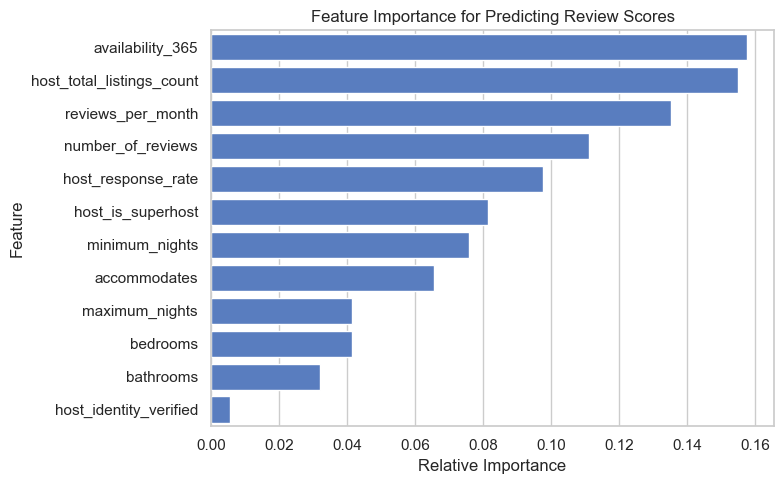

availability_365             0.157697
host_total_listings_count    0.155039
reviews_per_month            0.135207
number_of_reviews            0.111086
host_response_rate           0.097592
host_is_superhost            0.081552
minimum_nights               0.075893
accommodates                 0.065427
maximum_nights               0.041427
bedrooms                     0.041401
bathrooms                    0.032162
host_identity_verified       0.005518
dtype: float64

In [62]:
importances = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=importances.values, y=importances.index)
plt.title("Feature Importance for Predicting Review Scores")
plt.xlabel("Relative Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

importances
